In [1]:
from datasets import load_dataset
train = load_dataset("osanseviero/twitter-airline-sentiment")["train"].to_pandas()
text_X = train['text']
y = train['airline_sentiment']
y = y.replace(['negative', 'neutral', 'positive'], [0, 1, 2])
pos_ratio = y.value_counts()[2] / y.value_counts().sum()
neg_ratio = y.value_counts()[0] / y.value_counts().sum()
neutral_ratio = y.value_counts()[1] / y.value_counts().sum()
print(f'Proportion of positive examples: {round(pos_ratio * 100, 2)}%')
print(f'Proportion of negative examples: {round(neg_ratio * 100, 2)}%')
print(f'Proportion of neutral examples: {round(neutral_ratio * 100, 2)}%')


Proportion of positive examples: 16.14%
Proportion of negative examples: 62.69%
Proportion of neutral examples: 21.17%


In [2]:
from sklearn.model_selection import train_test_split
text_X_train, text_X_test, y_train, y_test = train_test_split(text_X, y,
    test_size=0.1, random_state=42)


In [3]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
device = "cuda:0" if torch.cuda.is_available() else "cpu"
# Load the tokenizer (converts text to tokens)
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")

# Load the pre-trained model
transformer_model = AutoModelForSequenceClassification.from_pretrained(
   "cardiffnlp/twitter-roberta-base-sentiment-latest"
)


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
import numpy as np
import tqdm
# Function that transforms a list of texts to their representation
# learned by the transformer.
def text_to_tensor(
   list_text_X_train: list,
   transformer_model: AutoModelForSequenceClassification,
   tokenizer: AutoTokenizer,
   device: str,
) -> np.ndarray:
   # Tokenize each text in the list one by one
   tokenized_text_X_train_split = []
   tokenized_text_X_train_split = [
       tokenizer.encode(text_x_train, return_tensors="pt")
       for text_x_train in list_text_X_train
   ]

   # Send the model to the device
   transformer_model = transformer_model.to(device)
   output_hidden_states_list = [None] * len(tokenized_text_X_train_split)

   for i, tokenized_x in enumerate(tqdm.tqdm(tokenized_text_X_train_split)):
       # Pass the tokens through the transformer model and get the hidden states
       # Only keep the last hidden layer state for now
       output_hidden_states = transformer_model(tokenized_x.to(device), output_hidden_states=True)[
           1
       ][-1]
       # Average over the tokens axis to get a representation at the text level.
       output_hidden_states = output_hidden_states.mean(dim=1)
       output_hidden_states = output_hidden_states.detach().cpu().numpy()
       output_hidden_states_list[i] = output_hidden_states

   return np.concatenate(output_hidden_states_list, axis=0)


In [5]:
# Let's vectorize the text using the transformer
list_text_X_train = text_X_train.tolist()
list_text_X_test = text_X_test.tolist()

X_train_transformer = text_to_tensor(list_text_X_train, transformer_model, tokenizer, device)
X_test_transformer = text_to_tensor(list_text_X_test, transformer_model, tokenizer, device)


100%|███████████████████████████████████████████████████████████████████████████████| 1464/1464 [00:17<00:00, 85.74it/s]


In [6]:
from concrete.ml.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV
# Let's build our model
model = XGBClassifier()

# A gridsearch to find the best parameters
parameters = {
    "n_bits": [2, 3],
    "max_depth": [1],
    "n_estimators": [10, 30, 50],
    "n_jobs": [-1],
}

# Now we have a representation for each tweet, we can train a model on these.
grid_search = GridSearchCV(model, parameters, cv=5, n_jobs=1, scoring="accuracy")
grid_search.fit(X_train_transformer, y_train)

# Check the accuracy of the best model
print(f"Best score: {grid_search.best_score_}")

# Check best hyperparameters
print(f"Best parameters: {grid_search.best_params_}")

# Extract best model
best_model = grid_search.best_estimator_


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Best score: 0.8367480196836677
Best parameters: {'max_depth': 1, 'n_bits': 3, 'n_estimators': 30, 'n_jobs': -1}


In [12]:
!pip install matplotlib

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 36.1 MB/s eta 0:00:00a 0:00:01
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 5.7 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 48.6 MB/s eta 0:00:00


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Accuracy: 0.8456


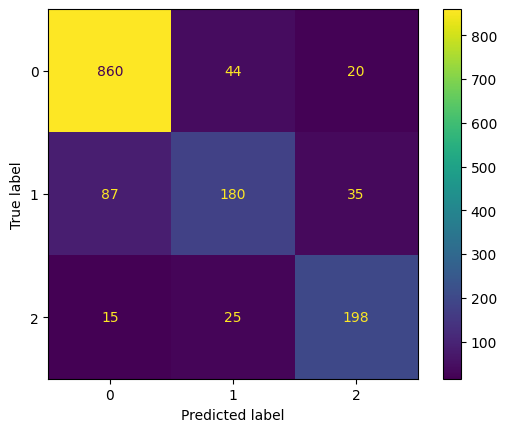

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Compute the metrics on the test set
y_pred = best_model.predict(X_test_transformer)
y_proba = best_model.predict_proba(X_test_transformer)

# Compute and plot the confusion matrix
matrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(matrix).plot()

# Compute the accuracy
accuracy_transformer_xgboost = np.mean(y_pred == y_test)
print(f"Accuracy: {accuracy_transformer_xgboost:.4f}")


In [26]:
import time
# Compile the model to get the FHE inference engine
# (this may take a few minutes depending on the selected model)
start = time.perf_counter()
best_model.compile(X_train_transformer)
end = time.perf_counter()
print(f"Compilation time: {end - start:.4f} seconds")

# Let's write a custom example and predict in FHE
tested_tweet = ["AirFrance is awesome, almost as much as Zama!"]
X_tested_tweet = text_to_tensor(tested_tweet, transformer_model, tokenizer, device)
clear_proba = best_model.predict_proba(X_tested_tweet)

# Now let's predict with FHE over a single tweet and print the time it takes
start = time.perf_counter()
decrypted_proba = best_model.predict_proba(X_tested_tweet,fhe="execute")
end = time.perf_counter()
fhe_exec_time = end - start
print(f"FHE inference time: {fhe_exec_time:.4f} seconds")


Compilation time: 10.4187 seconds


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.28it/s]


FHE inference time: 2.5172 seconds


In [27]:
print(f"Probabilities from the FHE inference: {decrypted_proba}")
print(f"Probabilities from the clear model: {clear_proba}")


Probabilities from the FHE inference: [[0.05164601 0.04560514 0.90274885]]
Probabilities from the clear model: [[0.05164601 0.04560514 0.90274885]]


In [28]:
# Let's save the model to be pushed to a server later
from concrete.ml.deployment import FHEModelDev
fhe_api = FHEModelDev("sentiment_fhe_model", best_model)
fhe_api.save()
